Enter the number of cluster: 10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning:

invalid value encountered in true_divide



Jaccard Coefficient:  0.3163932803656748
Rand Index:  0.7157608431323399
--------------------------------------------
printing Mu,Sigma and  Pi values after iteration
Pi:  [0.01160542 0.0170846  0.01316829 0.01166656 0.01740812 0.53807492
 0.05250018 0.3114126  0.01160542 0.01547389]
Mu:  [[ 1.          1.04333333  1.10666667  1.13333334  1.14166666  3.65166667
   4.70833334  6.37833334  6.05333334  7.41833334  7.03500001  7.04500001]
 [ 1.          1.48276252  1.97807679  4.60394492  4.25493939  2.82462747
   2.31433329  2.10793672  1.40910491  1.11065749  1.02806676  1.02240114]
 [ 1.          1.16155335  2.02387298  3.45093949  3.40050291 10.34985263
   7.24869471  6.22660981  3.16599926  1.67067292  1.88743879  2.22724637]
 [ 1.          0.92114235  1.29530559  2.4943451   2.63256073  2.31729037
   4.55057285  5.62541266  3.77797472  4.15032525  4.42598447  2.9138755 ]
 [ 1.          0.94777778  1.06222222  1.44        1.84555556  3.46888889
   7.35        8.64666667  5.18444444  3

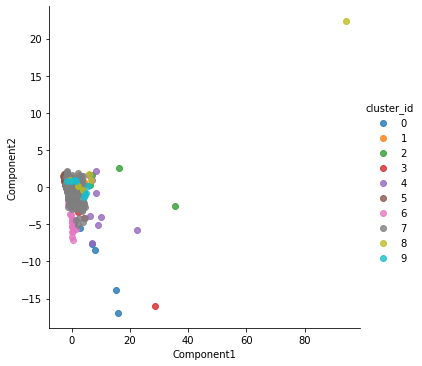

In [57]:
# Gaussian Mixture Model implementation

#necessary packages for importing
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA



#Read data from text file as numpy ndarray
  
data = np.genfromtxt("/content/iyer.txt", dtype='float', delimiter="\t")                    #change the file name here as required and for the demo data GMM.txt set the delimiter as one empty space Ex: " "
ground_truth = data[:,1]
data = np.delete(data, [0,1], axis=1)

dataIds = np.genfromtxt("/content/iyer.txt", delimiter="\t", dtype=str, usecols=0)           #change the file name here as required



C = int(input("Enter the number of cluster: "))
#Default initialization for report dataset                                                   #lines 27 to 37 contains the default initialization of the parameters

n_iters = 100
smooth = 1e-9
threshold = 1e-9
d = data.shape[1]
shape = data.shape
n,m = shape
initial_pi = np.full(shape = C, fill_value = 1/C)
weights = np.full( shape = shape, fill_value = 1/C)
random_row = np.random.randint(low = 0, high = n, size = C)
initial_mu = [data[row_index,:] for row_index in random_row]
initial_sigma = [np.cov(data.T) for _ in range(C)]


#initialization parameters values for demo dataset                                           #lines 42 to 52 contains the manual user initialization of the parameters

# n_iters = 100                                                                              #To change number of maximum iterations
# shape=data.shape
# d = data.shape[1]
# shape = data.shape
# n,m = shape
# init_pi = [0.5,0.5] #pi initialization                                                     #To initialize the Pi value
# initial_pi = [np.asarray(ele,dtype = float) for ele in init_pi]
# init_mu = [[0,0],[1,1]]  #mu initialization                                                #To initialize the Mu value
# initial_mu = [np.asarray(ele , dtype = float) for ele in init_mu]
# init_sigma = [[[1,1],[1,1]],[[2,2],[2,2]]] #sigma initializatoin                           #To initialize the sigma value
# initial_sigma = [np.cov(data.T) for _ in range(C)]

mu = initial_mu
sigma = initial_sigma
pi = initial_pi


def  Estep(X, mu, pi,sigma):                                                                  #performs estimation step
  N = X.shape[0]
  gamma = np.zeros((N,C))
  const_c = np.zeros(C)  
  # mu = mu if initial_mu is None else initial_mu
  # pi = pi if initial_pi is None else initial_pi
  # sigma = sigma if initial_sigma is None else initial_sigma
  for c in range(C):
    distribution = multivariate_normal(mu[c],sigma[c],allow_singular=True)
    gamma[:,c] = distribution.pdf(X)
    numerator = gamma * pi #smooth value included
    denominator = numerator.sum(axis=1)[:,np.newaxis]
    cluster_probability = numerator / denominator 
  return cluster_probability  

def Mstep(X, gamma):                                                                        #performs modification step
  N = X.shape[0]
  C = gamma.shape[1]
  d = X.shape[1]
  pi = np.mean(gamma, axis = 0)
  mu = np.dot(gamma.T, X) / np.sum(gamma, axis = 0)[:,np.newaxis]
  for c in range(C):
    x = X - mu[c, :]  
    gamma_diag = np.diag(gamma[:,c])
    x_mu = np.matrix(x)
    gamma_diag = np.matrix(gamma_diag)
    sigma_c = x.T * gamma_diag * x
    sigma[c]=(sigma_c) / np.sum(gamma, axis = 0)[:,np.newaxis][c]
  for i,element in enumerate(sigma):
    np.fill_diagonal(sigma[i], element.diagonal() + smooth)
  return pi,mu,sigma

#loss function
def loss_function(X,pi,mu,sigma):                                                             #computes overal loss value
  N = X.shape[0]
  C = gamma.shape[1]
  loss = np.zeros((N, C))
  for c in range(C):
    dist = multivariate_normal(mu[c],sigma[c],allow_singular=True)           #smooth value included
    loss[:,c] = gamma[:,c] * (np.log(pi[c]+0.00001)+dist.logpdf(X)-np.log(gamma[:,c]+0.000001))
  loss = np.sum(loss)
  return loss

def jaccard_and_rand(ground_truth,clusterid,data):                                           #computes the metrices Jaccard Coefficient and Rand Index
  data_array = np.asarray(data, dtype = float)
  true_positive = 0
  true_negative = 0
  false_positive=0
  false_negative=0
  for i in range(len(data_array)):
    for j in range(len(data_array)):
      if ground_truth[i]==ground_truth[j]:
        if clusterid[i]==clusterid[j]:
          true_positive=true_positive+1
        else:
          false_negative=false_negative+1
      elif ground_truth[i]!=ground_truth[j]:
        if clusterid[i]==clusterid[j]:
          false_positive=false_positive+1
        else:
          true_negative=true_negative+1
  jaccard=(true_positive)/(true_positive+false_positive+false_negative)
  rand=(true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative)
  return jaccard,rand     


def PCA_DimensionalityReduction(data,weights):                                                   #performs dimensionality reduction and then visualization
  pca_output = PCA(n_components=2).fit_transform(data)
  pca_output =np.asarray(pca_output)
  weights = np.asarray(weights)
  pca_output_df = pd.DataFrame(pca_output, columns=['Component1','Component2'], index=ground_truth)
  weights_df = pd.DataFrame(weights)
  pca_output_df['cluster_id'] = weights
  #plotting using seaborn
  lm = sns.lmplot(x='Component1', y='Component2', data=pca_output_df, fit_reg=False, hue='cluster_id')
  plt.show()


def visualization(data,weights):                                                                  #perfoems only visualization without dimensionality reduction    
  data_output =np.asarray(data)
  weights = np.asarray(weights)
  pca_output_df = pd.DataFrame(data_output, columns=['Column1','Column2'], index=ground_truth)
  weights_df = pd.DataFrame(weights)
  pca_output_df['cluster_id'] = weights

  #plotting using seaborn
  lm = sns.lmplot(x='Column1', y='Column2', data=pca_output_df, fit_reg=False, hue='cluster_id')
  plt.show()

#fitting and predicting                                                                             #fits the model and predicts the labels
for i , ele in enumerate(sigma):
  np.fill_diagonal(sigma[i],ele.diagonal() + smooth)
old_loss = None
for run in range(n_iters):  
  gamma  = Estep(data,mu,pi,sigma)
  pi = gamma.mean(axis=0)
  pi,mu,sigma = Mstep(data,gamma)
  new_loss = loss_function(data,pi,mu,sigma)
  if old_loss !=None and abs(new_loss - old_loss) <= threshold:
    break
  old_loss = new_loss

labels = np.zeros((data.shape[0],C))    
for c in range(C):
  distribution = multivariate_normal(mean = mu[c], cov = sigma[c], allow_singular=True)
  labels[:,c] = distribution.pdf(data)
numerator = labels * pi
denominator = numerator.sum(axis=1)[:,np.newaxis]
weights = numerator / denominator
weights  = weights.argmax(1)

jacc,rand = jaccard_and_rand(ground_truth,weights,data)
print("Jaccard Coefficient: ",jacc)
print("Rand Index: ",rand)
print("--------------------------------------------")
print("printing Mu,Sigma and  Pi values after iteration")
print("Pi: ", pi)
print("Mu: ", mu)
print("Sigma: ",sigma)


#passing Data and predicted labels to PCA when number of attributes in data is > 2 and Visuzlization
num_cols = np.shape(data)[1]
if num_cols > 2:
  PCA_DimensionalityReduction(data,weights)
else:
  visualization(data, weights)
